# Predictiong New York Real Estate Prices based on property attributes
With this dataset, I make use of multiple different regression models to try and predict the prices of properties in the New York.

# Loading in the data

In [1]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
# Read New York City property sales data
import pandas as pd

df_explore = pd.read_csv(DATA_PATH + 'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')
df_explore.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,$ - 0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,$ - 0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,$ - 0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,$ - 0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,$ - 0,01/01/2019


In [2]:
# Change column names: replace spaces with underscores (for potential bugs) and 
# make lowercase for ease of typing
df_explore.columns = df_explore.columns.str.lower().str.replace(' ', '_')
df_explore.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'ease-ment',
       'building_class_at_present', 'address', 'apartment_number', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')

Exploring size of dataset. Looks like we have roughly 21 descriptors and 23,040 entries.

In [3]:
df_explore.shape

(23040, 21)

In [4]:
%%capture
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

# Exploratory Data Analysis

In [ ]:
# Get Pandas Profiling Report
from pandas_profiling import ProfileReport
Report = ProfileReport(df_explore, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df_explore.isnull().sum()

borough                               0
neighborhood                          0
building_class_category               0
tax_class_at_present                  1
block                                 0
lot                                   0
ease-ment                         23040
building_class_at_present             1
address                               0
apartment_number                  17839
zip_code                              1
residential_units                     1
commercial_units                      1
total_units                           1
land_square_feet                     53
gross_square_feet                     1
year_built                           35
tax_class_at_time_of_sale             0
building_class_at_time_of_sale        0
sale_price                            0
sale_date                             0
dtype: int64

Drop 'easement' column since it's unsupported and appears to be all NANs

In [6]:
df_explore.drop(columns='ease-ment', inplace=True)
df_explore.shape

(23040, 20)

Drop apartment_number since 77.4% of values are missing

In [7]:
df_explore.drop(columns='apartment_number', inplace=True)
df_explore.shape

(23040, 19)

First, we must drop special characters in our sale price data column and convert to integers in order to be able to mathematically manipulte them.

In [8]:
# The Pandas Profiling Report showed that SALE_PRICE was read as strings
# Convert it to integers to be able to sort/manipulate mathematically
df_explore.info()
df_explore['sale_price']
df_explore['sale_price'] = df_explore['sale_price'].str.replace('$', '').str.replace('-', '').str.replace(',', '').astype(int)
df_explore.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   borough                         23040 non-null  int64  
 1   neighborhood                    23040 non-null  object 
 2   building_class_category         23040 non-null  object 
 3   tax_class_at_present            23039 non-null  object 
 4   block                           23040 non-null  int64  
 5   lot                             23040 non-null  int64  
 6   building_class_at_present       23039 non-null  object 
 7   address                         23040 non-null  object 
 8   zip_code                        23039 non-null  float64
 9   residential_units               23039 non-null  float64
 10  commercial_units                23039 non-null  float64
 11  total_units                     23039 non-null  float64
 12  land_square_feet                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


borough                             int64
neighborhood                       object
building_class_category            object
tax_class_at_present               object
block                               int64
lot                                 int64
building_class_at_present          object
address                            object
zip_code                          float64
residential_units                 float64
commercial_units                  float64
total_units                       float64
land_square_feet                   object
gross_square_feet                 float64
year_built                        float64
tax_class_at_time_of_sale           int64
building_class_at_time_of_sale     object
sale_price                          int64
sale_date                          object
dtype: object

It appears that there's a lot of zeroes in our dataset for unknown reasons. These will have to be dropped since this might due to gifts/inheritances or just unknown data that was recorded as 0. They give us no valuable information that aid in predicting sale price.

In [9]:
df_explore['sale_price'].value_counts()

0          6909
10          199
800000      125
750000      121
650000      120
           ... 
737500        1
714800        1
2456000       1
652233        1
892500        1
Name: sale_price, Length: 3831, dtype: int64

In [10]:
df_explore['sale_price'].unique()

array([     0, 550000, 200000, ..., 689419, 574850, 892500])

In [11]:
#casting to a list so we can sort and view all values
sale_price_list = df_explore['sale_price'].tolist()
sale_price_list.sort()
sale_price_list
sale_price_list[:-10]
sale_price_list.sort(reverse=True)
sale_price_list

[850000000,
 565754371,
 422000000,
 389858000,
 335000000,
 277700000,
 274300000,
 260000000,
 239958219,
 237500000,
 214200000,
 212500000,
 200000000,
 189109922,
 189109922,
 130500000,
 130442381,
 129500000,
 114436164,
 114436164,
 105800000,
 90500000,
 87900000,
 81000000,
 79950000,
 79950000,
 79451009,
 75500000,
 75500000,
 75000000,
 75000000,
 75000000,
 75000000,
 75000000,
 75000000,
 68806000,
 68000000,
 66500000,
 64250000,
 58000000,
 55525000,
 55000000,
 52250000,
 44000000,
 43799464,
 43300000,
 41250000,
 40800000,
 40800000,
 40800000,
 40433512,
 39285000,
 39201783,
 38760000,
 38500000,
 38000000,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36681561,
 36000000,
 36000000,
 36000000,
 35590000,
 34365938,
 33500000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,
 33000000,


# Getting rid of sale_price less than 500

In [12]:
df_explore = df_explore[(df_explore['sale_price'] > 500)]
df_explore.shape

(15826, 19)

Since ONE FAMILY DWELLINGS is my most common category, I will be focusing on that one type of real-estate  so we are **not** comparing apples to oranges.

In [13]:
df_explore['building_class_category'].unique()

array(['01 ONE FAMILY DWELLINGS', '13 CONDOS - ELEVATOR APARTMENTS',
       '10 COOPS - ELEVATOR APARTMENTS', '02 TWO FAMILY DWELLINGS',
       '03 THREE FAMILY DWELLINGS', '41 TAX CLASS 4 - OTHER',
       '08 RENTALS - ELEVATOR APARTMENTS',
       '07 RENTALS - WALKUP APARTMENTS', '44 CONDO PARKING',
       '47 CONDO NON-BUSINESS STORAGE', '05 TAX CLASS 1 VACANT LAND',
       '43 CONDO OFFICE BUILDINGS', '09 COOPS - WALKUP APARTMENTS',
       '04 TAX CLASS 1 CONDOS', '15 CONDOS - 2-10 UNIT RESIDENTIAL',
       '17 CONDO COOPS', '26 OTHER HOTELS', '29 COMMERCIAL GARAGES',
       '06 TAX CLASS 1 - OTHER', '12 CONDOS - WALKUP APARTMENTS',
       '27 FACTORIES', '22 STORE BUILDINGS', '31 COMMERCIAL VACANT LAND',
       '45 CONDO HOTELS', '30 WAREHOUSES',
       '32 HOSPITAL AND HEALTH FACILITIES', '14 RENTALS - 4-10 UNIT',
       '21 OFFICE BUILDINGS', '46 CONDO STORE BUILDINGS',
       '25 LUXURY HOTELS', '37 RELIGIOUS FACILITIES',
       '33 EDUCATIONAL FACILITIES', '49 CONDO WAREHOUSES

In [14]:
df_explore['building_class_category'].value_counts()

01 ONE FAMILY DWELLINGS                       3290
10 COOPS - ELEVATOR APARTMENTS                3042
02 TWO FAMILY DWELLINGS                       2642
13 CONDOS - ELEVATOR APARTMENTS               2459
03 THREE FAMILY DWELLINGS                      744
09 COOPS - WALKUP APARTMENTS                   612
07 RENTALS - WALKUP APARTMENTS                 412
15 CONDOS - 2-10 UNIT RESIDENTIAL              346
04 TAX CLASS 1 CONDOS                          308
44 CONDO PARKING                               285
17 CONDO COOPS                                 266
12 CONDOS - WALKUP APARTMENTS                  204
05 TAX CLASS 1 VACANT LAND                     175
22 STORE BUILDINGS                             161
14 RENTALS - 4-10 UNIT                         103
29 COMMERCIAL GARAGES                           92
08 RENTALS - ELEVATOR APARTMENTS                81
43 CONDO OFFICE BUILDINGS                       67
30 WAREHOUSES                                   64
21 OFFICE BUILDINGS            

# Reducing Dataset to ONE FAMILY DWELLINGS for similar comparison

In [15]:
df_explore = df_explore[(df_explore['building_class_category']=='01 ONE FAMILY DWELLINGS')]
df_explore.shape

(3290, 19)

Since this is a real estate dataset, and the real-estate market is heavily connected to time, we will be splitting the data by a date that will give us roughly a 80/20 split for train and test after we divide the dataset into target and determining factors. We want these two datsets to be connected somehow so we will set the datframe index to be the sale_date column.

In [16]:
df_explore['sale_date'].unique()
#df_explore.index.unique()

array(['01/01/2019', '01/02/2019', '01/03/2019', '01/04/2019',
       '01/06/2019', '01/07/2019', '01/08/2019', '01/09/2019',
       '01/10/2019', '01/11/2019', '01/13/2019', '01/14/2019',
       '01/15/2019', '01/16/2019', '01/17/2019', '01/18/2019',
       '01/21/2019', '01/22/2019', '01/23/2019', '01/24/2019',
       '01/25/2019', '01/28/2019', '01/29/2019', '01/30/2019',
       '01/31/2019', '02/01/2019', '02/03/2019', '02/04/2019',
       '02/05/2019', '02/06/2019', '02/07/2019', '02/08/2019',
       '02/11/2019', '02/12/2019', '02/13/2019', '02/14/2019',
       '02/15/2019', '02/17/2019', '02/18/2019', '02/19/2019',
       '02/20/2019', '02/21/2019', '02/22/2019', '02/25/2019',
       '02/26/2019', '02/27/2019', '02/28/2019', '03/01/2019',
       '03/04/2019', '03/05/2019', '03/06/2019', '03/07/2019',
       '03/08/2019', '03/09/2019', '03/11/2019', '03/12/2019',
       '03/13/2019', '03/14/2019', '03/15/2019', '03/17/2019',
       '03/18/2019', '03/19/2019', '03/20/2019', '03/21

In [17]:
df_explore['sale_date'].value_counts()

01/31/2019    80
03/29/2019    65
02/28/2019    59
01/15/2019    58
01/24/2019    58
              ..
03/17/2019     1
02/03/2019     1
04/14/2019     1
02/17/2019     1
01/13/2019     1
Name: sale_date, Length: 95, dtype: int64

# Setting sale_date to index
Finalizing datset to work with

In [18]:
df_explore['sale_date'] = pd.to_datetime(df_explore['sale_date'])
df_explore.dtypes
df = df_explore.set_index('sale_date')
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price
sale_date,,,,,,,,,,,,,,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000
2019-01-01,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000
2019-01-02,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000
2019-01-02,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000


# Target is 'Sale Price' of the property making this a regression problem due to the **continous numbers** that can be predicted.


In [19]:
target = 'sale_price'
y = df[target]
X = df.drop(columns = target, axis=1)
X.head()
print(y.head())

sale_date
2019-01-01    550000
2019-01-01    200000
2019-01-02    810000
2019-01-02    125000
2019-01-02    620000
Name: sale_price, dtype: int64


# Train Test Split
We want roughly a 80/20 split

In [20]:
df.shape

(3290, 18)

In [21]:
# Goal for 80% of the data is roughly:
3290*0.8

2632.0

In [22]:
cutoff = '2019-04-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [23]:
X_train.shape

(2627, 17)

In [24]:
X_test.shape

(663, 17)

Plotting Sale Price to get an idea of the distribution.

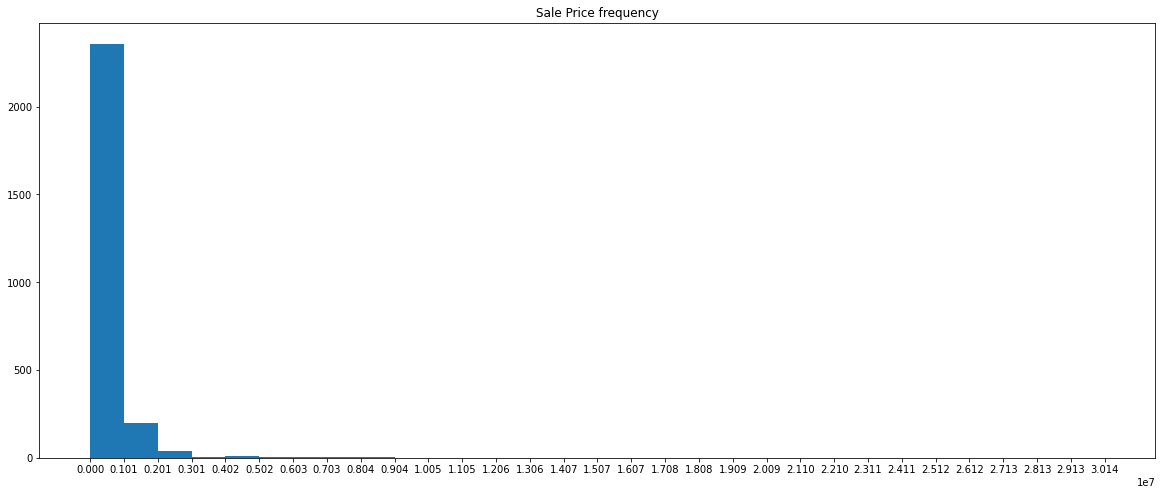

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
n, bins, patches = plt.hist(y_train, bins=30)
plt.xticks(bins)
plt.title('Sale Price frequency')
plt.show()

In [26]:
y_train.value_counts()

500000     37
550000     36
450000     33
525000     31
600000     29
           ..
442900      1
672000      1
1030000     1
6600000     1
104000      1
Name: sale_price, Length: 967, dtype: int64

In [27]:
y_train.describe()

count    2.627000e+03
mean     7.136693e+05
std      1.023682e+06
min      1.000000e+03
25%      4.372750e+05
50%      5.600000e+05
75%      7.750000e+05
max      3.013936e+07
Name: sale_price, dtype: float64

In [28]:
y_train.max()

30139360

The Sale Price target data is skewed to the right so we have to log transform it to get a normal distribution...

# Log Transformed to get normal distribution

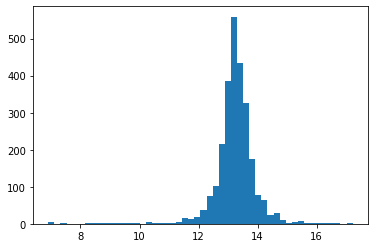

In [29]:
import numpy as np

y_train_log = np.log1p(y_train)
plt.hist(y_train_log, bins=50)
plt.show()

In [30]:
y_train_log.head()

sale_date
2019-01-01    13.217675
2019-01-01    12.206078
2019-01-02    13.604791
2019-01-02    11.736077
2019-01-02    13.337476
Name: sale_price, dtype: float64

In [31]:
y_train_log.shape

(2627,)

Exploring possible relationship and looking for major outliers

In [32]:
# Plotly Express scatter plot of GROSS_SQUARE_FEET vs SALE_PRICE
import plotly.express as px
px.scatter(data_frame = df, x='gross_square_feet', y='sale_price')

In [33]:
# Add an OLS (Ordinary Least Squares) trendline,
# to see how the outliers influence the "line of best fit"
px.scatter(data_frame= df, x='gross_square_feet', y='sale_price', trendline='ols')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [34]:
# check to see if we will need to import SimpleImputer
df.isnull().sum()

borough                           0
neighborhood                      0
building_class_category           0
tax_class_at_present              0
block                             0
lot                               0
building_class_at_present         0
address                           0
zip_code                          0
residential_units                 0
commercial_units                  0
total_units                       0
land_square_feet                  0
gross_square_feet                 0
year_built                        0
tax_class_at_time_of_sale         0
building_class_at_time_of_sale    0
sale_price                        0
dtype: int64

# Establishing a Baseline
Since this is a regression problem, we will be calculating mean_absolute_error to establish a baseline.

In [35]:
from sklearn.metrics import mean_absolute_error
# Making a column based on means of the sale price for comparison should be all 
# the same value
y_pred = [y_train.mean()]*len(y_train)
y_pred

baseline_mae = mean_absolute_error(y_train, y_pred)
print('Baseline Mean Absolute Error:', baseline_mae)

Baseline Mean Absolute Error: 348211.56478193647


# Building a Model

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from category_encoders import OneHotEncoder
from sklearn.metrics import r2_score

**Linear Regression**

In [37]:
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                         LinearRegression())
#note we will be using log transformed y_train
model_lr.fit(X_train, y_train_log)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood', 'building_class_category',
                                     'tax_class_at_present',
                                     'building_class_at_present', 'address',
                                     'land_square_feet',
                                     'building_class_at_time_of_sale'],
                               use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [38]:
# get predictions for this log tranformed target
y_pred_log_lr = model_lr.predict(X_test)

# reverse log tranform your log tranformed target
y_pred_lr = np.expm1(y_pred_log_lr)

# check metrics
print('Linear Regression test MAE:', mean_absolute_error(y_test, y_pred_lr))
print('Linear Regression test Accuracy:', r2_score(y_test, y_pred_lr))

Linear Regression test MAE: 219358.27660112543
Linear Regression test Accuracy: 0.7406148560049363


**Ridge**

In [39]:
model_r = make_pipeline(OneHotEncoder(use_cat_names=True),
                         Ridge(alpha=200))
model_r.fit(X_train, y_train_log)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood', 'building_class_category',
                                     'tax_class_at_present',
                                     'building_class_at_present', 'address',
                                     'land_square_feet',
                                     'building_class_at_time_of_sale'],
                               use_cat_names=True)),
                ('ridge', Ridge(alpha=200))])

In [40]:
# get predictions for this log tranformed target
y_pred_log_r = model_r.predict(X_test)

# reverse log tranform your log tranformed target
y_pred_r = np.expm1(y_pred_log_r)

# check metrics
print('Ridge Regression test MAE:', mean_absolute_error(y_test, y_pred_r))
print('Ridge Regression test Accuracy:', r2_score(y_test, y_pred_r))

Ridge Regression test MAE: 261205.64072759167
Ridge Regression test Accuracy: 0.4794339723347416


**Random Forest Regressor**

In [41]:
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder

model_rf = make_pipeline(OrdinalEncoder(),
                         RandomForestRegressor(random_state=42))
model_rf.fit(X_train, y_train_log)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['neighborhood', 'building_class_category',
                                      'tax_class_at_present',
                                      'building_class_at_present', 'address',
                                      'land_square_feet',
                                      'building_class_at_time_of_sale'],
                                mapping=[{'col': 'neighborhood',
                                          'data_type': dtype('O'),
                                          'mapping': OCEAN PARKWAY-NORTH        1
QUEENS VILLAGE             2
PELHAM PARKWAY SOUTH       3
FLATBUSH-CENTRAL           4
FLATBUS...
                                         {'col': 'land_square_feet',
                                          'data_type': dtype('O'),
                                          'mapping': 6,800      1
4,000      2
3,500      3
1,710      4
2,000      5
        ... 
3,230    927
2,121    928
4,361   

In [42]:
# get predictions for this log tranformed target
y_pred_log_rf = model_rf.predict(X_test)

# reverse log tranform your log tranformed target
y_pred_rf = np.expm1(y_pred_log_rf)

# check metrics
print('Random Forest Regression test MAE:', mean_absolute_error(y_test, y_pred_rf))
print('Random Forest test Accuracy:', r2_score(y_test, y_pred_rf))

Random Forest Regression test MAE: 284820.77342128806
Random Forest test Accuracy: 0.7201233601842327


In [43]:
from xgboost import XGBRegressor
model_xgb = make_pipeline(OrdinalEncoder(),
                          XGBRegressor(random_state=42))
model_xgb.fit(X_train, y_train_log)

[03:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['neighborhood', 'building_class_category',
                                      'tax_class_at_present',
                                      'building_class_at_present', 'address',
                                      'land_square_feet',
                                      'building_class_at_time_of_sale'],
                                mapping=[{'col': 'neighborhood',
                                          'data_type': dtype('O'),
                                          'mapping': OCEAN PARKWAY-NORTH        1
QUEENS VILLAGE             2
PELHAM PARKWAY SOUTH       3
FLATBUSH-CENTRAL           4
FLATBUS...
Length: 2615, dtype: int64},
                                         {'col': 'land_square_feet',
                                          'data_type': dtype('O'),
                                          'mapping': 6,800      1
4,000      2
3,500      3
1,710      4
2,000      5
        ... 
3,230

In [44]:
# get predictions for this log tranformed target
y_pred_log_xgb = model_xgb.predict(X_test)

# reverse log tranform your log tranformed target
y_pred_xgb = np.expm1(y_pred_log_xgb)

# check metrics
print('Random Forest Regression test MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('Linear Regression test Accuracy:', r2_score(y_test, y_pred_xgb))

Random Forest Regression test MAE: 368873.54108927224
Linear Regression test Accuracy: 0.5064283166249508


# Comparing model errors & accuracies

**Predictive Modeling**: when the goal is to make the most accurate predictions possible. In this kind of model, the Mean Absolute Error tells us how well the model is doing. The units for MAE are the same as the units for predicted values, in this case being $.

In [46]:
models = {'linear': round(mean_absolute_error(y_test, y_pred_lr)),
          'ridge': round(mean_absolute_error(y_test, y_pred_r)), 
          'randomforest': round(mean_absolute_error(y_test, y_pred_rf)), 
          'xgb': round(mean_absolute_error(y_test, y_pred_xgb))}
models                                                                                                                                           

{'linear': 219358, 'randomforest': 284821, 'ridge': 261206, 'xgb': 368874}

In [47]:
find_min = min(models, key=models.get)
print("Model with least error:", find_min)

Model with least error: linear


Looking at the model with the lowest MAE at $219,358, that is still a pretty high margin of error for trying to predict a property's value. That would be the difference between a sale or not, talking about completely different budgets here.

**Inferential Modeling**: understanding relationships between our x and y variable. R^2 is interpreted as the percent variation in our y variable that is explained by all the X variables included in the model.

In [59]:
models_r = {'linear': round(r2_score(y_test, y_pred_lr), 3),
          'ridge': round(r2_score(y_test, y_pred_r), 3), 
          'randomforest': round(r2_score(y_test, y_pred_rf), 3), 
          'xgb': round(r2_score(y_test, y_pred_xgb), 3)}
models_r

{'linear': 0.741, 'randomforest': 0.72, 'ridge': 0.479, 'xgb': 0.506}

In [62]:
find_max_r = max(models_r, key=models_r.get)
print("Model with highest accuracy:", find_max_r)

Model with highest accuracy: linear


Linear appeared to have the highest accuracy when comparing r^2 values as well. Even then though, 0.741 is not the best. But we will take the linear model to look at the relationships of the coefficients:

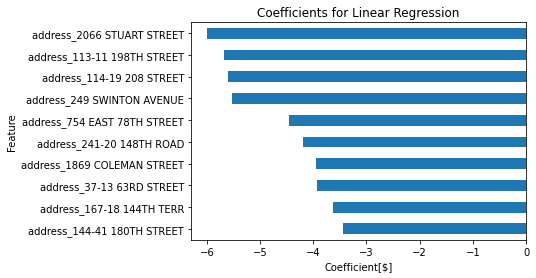

In [63]:
coefficients = model_lr.named_steps['linearregression'].coef_
features = model_lr.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient[$]')
plt.ylabel('Feature')
plt.title('Coefficients for Linear Regression');

Looks like the age-old adage in real-estate of LOCATION LOCATION LOCATION being the number one factor in determining prices, is proven to be true once again. Because the address column is high cardinality, an improvement to this model might be to remove this column altogether.

Another critique is that the dataset might be too small to achieve any greater accurcies.